# Import libraries

In [1]:
import os
import sys
import pypots
import numpy as np
import benchpots
import matplotlib.pyplot as plt
from pypots.optim import Adam
from pypots.imputation import SAITS, BRITS, USGAN, GPVAE, MRNN
from pypots.utils.random import set_random_seed
#from functions.toolkits import toolkits
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from MAEModify.error import calc_mae


2025-11-27 03:31:58.250374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764225118.266831  140792 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764225118.271890  140792 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-27 03:31:58.289060: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidge


████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



# Load dataset

In [2]:
set_random_seed()
physionet2012_dataset = benchpots.datasets.preprocess_physionet2012(subset="all", rate=0.1)
print(physionet2012_dataset.keys())

2025-11-27 03:32:03 [INFO]: Have set the random seed as 2022 for numpy and pytorch.
2025-11-27 03:32:03 [INFO]: You're using dataset physionet_2012, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/physionet_2012
2025-11-27 03:32:03 [INFO]: Dataset physionet_2012 has already been downloaded. Processing directly...
2025-11-27 03:32:03 [INFO]: Dataset physionet_2012 has already been cached. Loading from cache directly...
2025-11-27 03:32:03 [INFO]: Loaded successfully!
/usr/local/lib/python3.11/dist-packages/benchpots/datasets/physionet_2012.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X 

dict_keys(['n_classes', 'n_steps', 'n_features', 'scaler', 'train_X', 'train_y', 'train_ICUType', 'val_X', 'val_y', 'val_ICUType', 'test_X', 'test_y', 'test_ICUType', 'val_X_ori', 'test_X_ori'])


In [3]:
dataset_for_training = {
    "X": physionet2012_dataset['train_X'],
}

dataset_for_validating = {
    "X": physionet2012_dataset['val_X'],
    "X_ori": physionet2012_dataset['val_X_ori'],
}

dataset_for_testing = {
    "X": physionet2012_dataset['test_X'],
}

test_X_indicating_mask = np.isnan(physionet2012_dataset['test_X_ori']) ^ np.isnan(physionet2012_dataset['test_X'])
test_X_ori = np.nan_to_num(physionet2012_dataset['test_X_ori']) 

# Train/Load Models

## SAITS

In [4]:
saits = SAITS(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    n_layers=1,
    d_model=256,
    d_ffn=128,
    n_heads=4,
    d_k=64,
    d_v=64,
    dropout=0.1,
    ORT_weight=1,  
    MIT_weight=1,
    batch_size=32,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-11-27 03:32:28 [INFO]: No given device, using default device: cpu
2025-11-27 03:32:28 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-11-27 03:32:28 [INFO]: Using customized MAE as the training loss function.
2025-11-27 03:32:28 [INFO]: Using customized MSE as the validation metric function.
2025-11-27 03:32:28 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 720,182


In [5]:
saits.load("../mae/tutorial_results/imputation/saits/20250422_T181642/SAITS.pypots")

2025-11-27 03:32:28 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/saits/20250422_T181642/SAITS.pypots


## BRITS

In [6]:
brits = BRITS(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=128,
    batch_size=32,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-11-27 03:32:34 [INFO]: No given device, using default device: cpu
2025-11-27 03:32:34 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-11-27 03:32:34 [INFO]: Using customized MAE as the training loss function.
2025-11-27 03:32:34 [INFO]: Using customized MSE as the validation metric function.
2025-11-27 03:32:34 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 239,344


In [7]:
brits.load("../mae/tutorial_results/imputation/brits/20250422_T181643/BRITS.pypots")

2025-11-27 03:32:35 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/brits/20250422_T181643/BRITS.pypots


## US-GAN

In [8]:
us_gan = USGAN(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=256,
    lambda_mse=1,
    dropout=0.1,
    G_steps=1,
    D_steps=1,
    batch_size=32,
    epochs=10,
    patience=3,
    G_optimizer=Adam(lr=1e-3),
    D_optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-11-27 03:32:39 [INFO]: No given device, using default device: cpu
2025-11-27 03:32:39 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-11-27 03:32:39 [INFO]: USGAN initialized with the given hyperparameters, the number of trainable parameters: 1,258,517


In [9]:
us_gan.load("../mae/tutorial_results/imputation/us_gan/20250422_T181643/USGAN.pypots")

2025-11-27 03:32:41 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/us_gan/20250422_T181643/USGAN.pypots


## GP-VAE

In [10]:
gp_vae = GPVAE(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    latent_size=37,
    encoder_sizes=(128,128),
    decoder_sizes=(256,256),
    kernel="cauchy",
    beta=0.2,
    M=1,
    K=1,
    sigma=1.005,
    length_scale=7.0,
    kernel_scales=1,
    window_size=24,
    batch_size=32,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-11-27 03:32:43 [INFO]: No given device, using default device: cpu
2025-11-27 03:32:43 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-11-27 03:32:43 [INFO]: GPVAE initialized with the given hyperparameters, the number of trainable parameters: 229,652


In [11]:
gp_vae.load("../mae/tutorial_results/imputation/gp_vae/20250422_T181643/GPVAE.pypots")

2025-11-27 03:32:46 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/gp_vae/20250422_T181643/GPVAE.pypots


## MRNN

In [12]:
mrnn = MRNN(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=128,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-11-27 03:32:50 [INFO]: No given device, using default device: cpu
2025-11-27 03:32:50 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-11-27 03:32:50 [INFO]: Using customized RMSE as the training loss function.
2025-11-27 03:32:50 [INFO]: Using customized MSE as the validation metric function.
2025-11-27 03:32:50 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 107,951


In [13]:
mrnn.load("../mae/tutorial_results/imputation/mrnn/20250422_T181643/MRNN.pypots")

2025-11-27 03:32:52 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/mrnn/20250422_T181643/MRNN.pypots


# Imputation Models

## SAITS

In [14]:
saits_results = saits.predict(dataset_for_testing)
saits_imputation = saits_results["imputation"]

## BRITS

In [15]:
brits_results = brits.predict(dataset_for_testing)
brits_imputation = brits_results["imputation"]

## US-GAN

In [16]:
us_gan_results = us_gan.predict(dataset_for_testing)
us_gan_imputation = us_gan_results["imputation"]

## GP-VAE

In [17]:
gp_vae_results = gp_vae.predict(dataset_for_testing)
gp_vae_imputation = gp_vae_results["imputation"]

## MRNN

In [18]:
mrnn_results = mrnn.predict(dataset_for_testing)
mrnn_imputation = mrnn_results["imputation"]

# AE/MAE Models

## SAITS

In [19]:
saits_mae, saits_ae = calc_mae(
    saits_imputation,
    test_X_ori,
    test_X_indicating_mask,
)

## BRITS

In [20]:
brits_mae, brits_ae = calc_mae(
    brits_imputation,
    test_X_ori,
    test_X_indicating_mask,
)

## US-GAN

In [21]:
usgan_mae, usgan_ae = calc_mae(
    us_gan_imputation,
    test_X_ori,
    test_X_indicating_mask,
)

## GP-VAE

In [22]:
gp_vae_imputation = np.squeeze(gp_vae_imputation, axis=1)

gpvae_mae, gpvae_ae = calc_mae(
    gp_vae_imputation,
    test_X_ori,
    test_X_indicating_mask,
)

## MRNN

In [23]:
mrnn_mae, mrnn_ae = calc_mae(
    mrnn_imputation,
    test_X_ori,
    test_X_indicating_mask,
)

# Gini Models

In [24]:
test_X_indicating_mask_general = test_X_indicating_mask
test_X_indicating_mask_general = test_X_indicating_mask_general.reshape(len(test_X_indicating_mask_general)* 48 * 37)

In [25]:
test_X_indicating_mask = test_X_indicating_mask.reshape(len(test_X_indicating_mask) * 48,  37)

## SAITS

In [26]:
saits_ae_general  = saits_ae
saits_ae_general = saits_ae_general.reshape(len(saits_ae_general)* 48 * 37)

In [27]:
saits_ae_mask_general = []

for i in range(len(test_X_indicating_mask_general)):
    if(test_X_indicating_mask_general[i] == True):
        saits_ae_mask_general.append(saits_ae_general[i])

saits_ae_mask_general = np.array(saits_ae_mask_general)

In [28]:
saits_ae = saits_ae.reshape(len(saits_ae) * 48 , 37)

In [29]:
def reshape_variables_v2(dataset):
       
        listaAux = []
        dataset_variable = []

        for i in range(37):

            for j in range(len(dataset)):
               
               listaAux.append(dataset[j][i])
            
            dataset_variable.append(listaAux)
            listaAux = []
        
        return dataset_variable

In [30]:
saits_ae = reshape_variables_v2(saits_ae)

In [31]:
test_X_indicating_mask = reshape_variables_v2(test_X_indicating_mask)

In [32]:
saits_ae_mask = []
aux_ae = []

for i in range(len(test_X_indicating_mask)):
    for j in range(len(test_X_indicating_mask[i])):
        if(test_X_indicating_mask[i][j] == True):
            aux_ae.append(saits_ae[i][j])
    
    saits_ae_mask.append(np.array(aux_ae))
    aux_ae = []


In [33]:
len(saits_ae_mask)

37

In [34]:
def sum_aes_variables(model_aes):
        model_ae_sum  = []
        model_ae_sum_variables  = []
        for variable in model_aes:
            for patient in variable:
                model_ae_sum.append(np.sum(patient))
            model_ae_sum_variables.append(model_ae_sum)
            model_ae_sum = []
        
        return model_ae_sum_variables

In [66]:
saits_ae_sum = sum_aes_variables(saits_ae_mask)

In [36]:
len(saits_ae_sum)

37

## BRITS

In [37]:
brits_ae_general  = brits_ae
brits_ae_general = brits_ae_general.reshape(len(brits_ae_general)* 48 * 37)

In [38]:
brits_ae_mask_general = []

for i in range(len(test_X_indicating_mask_general)):
    if(test_X_indicating_mask_general[i] == True):
        brits_ae_mask_general.append(brits_ae_general[i])

brits_ae_mask_general = np.array(brits_ae_mask_general)

In [39]:
brits_ae = brits_ae.reshape(len(brits_ae) * 48 , 37)

In [40]:
brits_ae = reshape_variables_v2(brits_ae)

In [41]:
brits_ae_mask = []
aux_ae = []

for i in range(len(test_X_indicating_mask)):
    for j in range(len(test_X_indicating_mask[i])):
        if(test_X_indicating_mask[i][j] == True):
            aux_ae.append(brits_ae[i][j])
    
    brits_ae_mask.append(np.array(aux_ae))
    aux_ae = []


In [42]:
brits_ae_sum = sum_aes_variables(brits_ae_mask)

In [43]:
len(brits_ae_sum)

37

## US-GAN

In [44]:
usgan_ae_general  = usgan_ae
usgan_ae_general = usgan_ae_general.reshape(len(usgan_ae_general)* 48 * 37)

In [45]:
usgan_ae_mask_general = []

for i in range(len(test_X_indicating_mask_general)):
    if(test_X_indicating_mask_general[i] == True):
        usgan_ae_mask_general.append(usgan_ae_general[i])

usgan_ae_mask_general = np.array(usgan_ae_mask_general)

In [46]:
usgan_ae = usgan_ae.reshape(len(usgan_ae) * 48 , 37)

In [47]:
usgan_ae = reshape_variables_v2(usgan_ae)

In [48]:
usgan_ae_mask = []
aux_ae = []

for i in range(len(test_X_indicating_mask)):
    for j in range(len(test_X_indicating_mask[i])):
        if(test_X_indicating_mask[i][j] == True):
            aux_ae.append(usgan_ae[i][j])
    
    usgan_ae_mask.append(np.array(aux_ae))
    aux_ae = []


In [49]:
usgan_ae_sum = sum_aes_variables(usgan_ae_mask)

In [50]:
len(usgan_ae_sum)

37

## GPVAE

In [51]:
gpvae_ae_general  = gpvae_ae
gpvae_ae_general = gpvae_ae_general.reshape(len(gpvae_ae_general)* 48 * 37)

In [52]:
gpvae_ae_mask_general = []

for i in range(len(test_X_indicating_mask_general)):
    if(test_X_indicating_mask_general[i] == True):
        gpvae_ae_mask_general.append(gpvae_ae_general[i])

gpvae_ae_mask_general = np.array(gpvae_ae_mask_general)

In [53]:
gpvae_ae = gpvae_ae.reshape(len(gpvae_ae) * 48 , 37)

In [54]:
gpvae_ae = reshape_variables_v2(gpvae_ae)

In [55]:
gpvae_ae_mask = []
aux_ae = []

for i in range(len(test_X_indicating_mask)):
    for j in range(len(test_X_indicating_mask[i])):
        if(test_X_indicating_mask[i][j] == True):
            aux_ae.append(gpvae_ae[i][j])
    
    gpvae_ae_mask.append(np.array(aux_ae))
    aux_ae = []


In [56]:
gpvae_ae_sum = sum_aes_variables(gpvae_ae_mask)

In [57]:
len(gpvae_ae_sum)

37

## MRNN

In [58]:
mrnn_ae_general  = mrnn_ae
mrnn_ae_general = mrnn_ae_general.reshape(len(mrnn_ae_general)* 48 * 37)

In [59]:
mrnn_ae_mask_general = []

for i in range(len(test_X_indicating_mask_general)):
    if(test_X_indicating_mask_general[i] == True):
        mrnn_ae_mask_general.append(mrnn_ae_general[i])

mrnn_ae_mask_general = np.array(mrnn_ae_mask_general)

In [60]:
mrnn_ae = mrnn_ae.reshape(len(mrnn_ae) * 48 , 37)

In [61]:
mrnn_ae = reshape_variables_v2(mrnn_ae)

In [62]:
mrnn_ae_mask = []
aux_ae = []

for i in range(len(test_X_indicating_mask)):
    for j in range(len(test_X_indicating_mask[i])):
        if(test_X_indicating_mask[i][j] == True):
            aux_ae.append(mrnn_ae[i][j])
    
    mrnn_ae_mask.append(np.array(aux_ae))
    aux_ae = []


In [63]:
mrnn_ae_sum = sum_aes_variables(mrnn_ae_mask)

In [64]:
len(mrnn_ae_sum)

37

In [65]:
len(mrnn_ae_sum[0])

192

# IC Models

## SAITS

In [49]:
bootstrap_saits = []

for i in range(len(saits_ae_mask)):
    bootstrap_saits.append(toolkits.bootstrap_v2(saits_ae_mask, i, 9000))

KeyboardInterrupt: 

In [52]:
lower_bound_saits = []
upper_bound_saits = []

for i in range(len(bootstrap_saits)):
    lower_bound_saits.append(np.percentile(bootstrap_saits[i], 2.5))
    upper_bound_saits.append(np.percentile(bootstrap_saits[i], 97.5))

print(lower_bound_saits)
print(upper_bound_saits)

[np.float64(0.5435100202757382), np.float64(0.6389517033853522), np.float64(0.6946863077170858), np.float64(0.3634579311834109), np.float64(0.47079322266190776), np.float64(0.5788795671171321), np.float64(0.2505328369706727), np.float64(0.5359367039997764), np.float64(0.5314053904702729), np.float64(0.5582454200626127), np.float64(0.6129390206193398), np.float64(0.49689047374883505), np.float64(0.4312899522539368), np.float64(0.43159689969416143), np.float64(0.48572429860568356), np.float64(0.449879075193115), np.float64(0.4872420601685669), np.float64(0.5402514549323488), np.float64(0.4547727387240157), np.float64(0.44747636759860077), np.float64(0.588078877124718), np.float64(0.5607873943935131), np.float64(0.5836259092018314), np.float64(0.42977249795158656), np.float64(0.4609105961379078), np.float64(0.5194343350930829), np.float64(0.4716154640173531), np.float64(0.4372355081746939), np.float64(0.4983646901925138), np.float64(0.5092987740476734), np.float64(0.5021311887394649), np.

In [53]:
mean_bound_saits = []

for i in range(len(lower_bound_saits)):
    mean_bound_saits.append((lower_bound_saits[i]+upper_bound_saits[i])/2)

print(mean_bound_saits)

[np.float64(0.6512606715207199), np.float64(0.7193784048414222), np.float64(0.7719023631164863), np.float64(0.40689248148923646), np.float64(0.4918988205623728), np.float64(0.6377318564462264), np.float64(0.3412823407129682), np.float64(0.5798599816719032), np.float64(0.5440548328533261), np.float64(0.5713696121807519), np.float64(0.6229507100641942), np.float64(0.5241553515562097), np.float64(0.4513667510066057), np.float64(0.44884052116810313), np.float64(0.492518669155238), np.float64(0.47209716820272307), np.float64(0.5197111647221075), np.float64(0.565393692779862), np.float64(0.47004153353056277), np.float64(0.4886920238531335), np.float64(0.6009966803246607), np.float64(0.5748301263847131), np.float64(0.6003694994012074), np.float64(0.45195908322083234), np.float64(0.48041272361026766), np.float64(0.5371019351699838), np.float64(0.4959125357742892), np.float64(0.4481209980725829), np.float64(0.5702833013297741), np.float64(0.5204102928290957), np.float64(0.5247078656146278), np.

## BRITS

In [54]:
bootstrap_brits = []

for i in range(len(brits_ae_mask)):
    bootstrap_brits.append(toolkits.bootstrap_v2(brits_ae_mask, i, 9000))

In [55]:
lower_bound_brits = []
upper_bound_brits = []

for i in range(len(bootstrap_brits)):
    lower_bound_brits.append(np.percentile(bootstrap_brits[i], 2.5))
    upper_bound_brits.append(np.percentile(bootstrap_brits[i], 97.5))

print(lower_bound_brits)
print(upper_bound_brits)

[np.float64(0.478584790231987), np.float64(0.5324684841311105), np.float64(0.7424264763855235), np.float64(0.3509549342994489), np.float64(0.5317157529916134), np.float64(0.5892287810978972), np.float64(0.2596704080558105), np.float64(0.6388700257599292), np.float64(0.572688991735357), np.float64(0.6023625025240293), np.float64(0.6217054626170403), np.float64(0.4871980988058966), np.float64(0.4127925753344459), np.float64(0.4205340189376448), np.float64(0.5011565122563202), np.float64(0.45776060185262396), np.float64(0.5120051664229581), np.float64(0.5910654533548468), np.float64(0.40989308446900735), np.float64(0.44217657126641197), np.float64(0.5195182931854484), np.float64(0.6451659456391505), np.float64(0.4857703134568306), np.float64(0.4492289245697797), np.float64(0.46623115771216345), np.float64(0.5162772219262227), np.float64(0.42429066722822156), np.float64(0.4378061505156451), np.float64(0.49119254681812957), np.float64(0.5426394886816664), np.float64(0.539274177971466), np.f

In [56]:
mean_bound_brits = []

for i in range(len(lower_bound_brits)):
    mean_bound_brits.append((lower_bound_brits[i]+upper_bound_brits[i])/2)

print(mean_bound_brits)

[np.float64(0.5951056718263642), np.float64(0.6476192480355113), np.float64(0.8009925516357834), np.float64(0.3946049862258218), np.float64(0.5549341598713683), np.float64(0.6508309772554206), np.float64(0.3517318403127996), np.float64(0.6672315173123172), np.float64(0.5910202055794678), np.float64(0.6149646720183661), np.float64(0.6311363441637652), np.float64(0.5149901840326134), np.float64(0.4313759761245102), np.float64(0.4360929093499247), np.float64(0.5075913711274518), np.float64(0.47871150848930927), np.float64(0.5418888102928887), np.float64(0.6321783208600812), np.float64(0.4225271815808874), np.float64(0.48469367501473387), np.float64(0.5333952134082027), np.float64(0.6580834123295086), np.float64(0.5010925320642796), np.float64(0.4683073412101571), np.float64(0.6315212437745643), np.float64(0.5332456705855251), np.float64(0.4484608466950658), np.float64(0.4488183967767265), np.float64(0.5620605615403933), np.float64(0.5584425537485169), np.float64(0.57336486288647), np.floa

## USGAN 

In [57]:
bootstrap_usgan = []

for i in range(len(usgan_ae_mask)):
    bootstrap_usgan.append(toolkits.bootstrap_v2(usgan_ae_mask, i, 9000))

In [58]:
lower_bound_usgan = []
upper_bound_usgan = []

for i in range(len(bootstrap_usgan)):
    lower_bound_usgan.append(np.percentile(bootstrap_usgan[i], 2.5))
    upper_bound_usgan.append(np.percentile(bootstrap_usgan[i], 97.5))

print(lower_bound_usgan)
print(upper_bound_usgan)

[np.float64(0.5180617431308812), np.float64(0.5355525135368893), np.float64(0.4978776867252705), np.float64(0.3399113330447707), np.float64(0.4553267804795127), np.float64(0.44422385624321964), np.float64(0.23143602840608635), np.float64(0.5081546752282472), np.float64(0.5231890879699242), np.float64(0.5205525659975465), np.float64(0.5454300640773584), np.float64(0.42965767026270796), np.float64(0.4313934056332262), np.float64(0.4319716742002413), np.float64(0.4912464449453926), np.float64(0.4442569773619454), np.float64(0.40225228407438257), np.float64(0.5590909562408958), np.float64(0.4383586388858223), np.float64(0.44421974907431494), np.float64(0.518819181475371), np.float64(0.5995971861532075), np.float64(0.49007389907698123), np.float64(0.41939306066414295), np.float64(0.4634819368099337), np.float64(0.4753544528590532), np.float64(0.4356316350115256), np.float64(0.43342628801882704), np.float64(0.4625161187379285), np.float64(0.5053848514888857), np.float64(0.5171478565879942), 

In [59]:
mean_bound_usgan = []

for i in range(len(lower_bound_usgan)):
    mean_bound_usgan.append((lower_bound_usgan[i]+upper_bound_usgan[i])/2)

print(mean_bound_usgan)

[np.float64(0.6130895070798852), np.float64(0.6063555798956477), np.float64(0.5834872527545446), np.float64(0.39289723966939244), np.float64(0.47853289078108624), np.float64(0.503682457373315), np.float64(0.344716174870629), np.float64(0.5426940232074604), np.float64(0.5333482442725737), np.float64(0.5335804512705986), np.float64(0.5552649500536394), np.float64(0.4551286112759626), np.float64(0.44955786027525335), np.float64(0.4502547305852219), np.float64(0.497518653322121), np.float64(0.46516191865899736), np.float64(0.4323477714197456), np.float64(0.5762590986291314), np.float64(0.4567349462499891), np.float64(0.4860363292901145), np.float64(0.5321207804054701), np.float64(0.6119352415986252), np.float64(0.5044708643412193), np.float64(0.43966819614352826), np.float64(0.5724568273234794), np.float64(0.49265031044076807), np.float64(0.4567987946087896), np.float64(0.4445061109931187), np.float64(0.5292381927546224), np.float64(0.515275552887615), np.float64(0.5391178018448055), np.fl

## GPVAE

In [60]:
bootstrap_gpvae = []

for i in range(len(gpvae_ae_mask)):
    bootstrap_gpvae.append(toolkits.bootstrap_v2(gpvae_ae_mask, i, 9000))

In [61]:
lower_bound_gpvae = []
upper_bound_gpvae = []

for i in range(len(bootstrap_gpvae)):
    lower_bound_gpvae.append(np.percentile(bootstrap_gpvae[i], 2.5))
    upper_bound_gpvae.append(np.percentile(bootstrap_gpvae[i], 97.5))

print(lower_bound_gpvae)
print(upper_bound_gpvae)

[np.float64(0.38565849046202133), np.float64(0.49348054988381673), np.float64(0.5781062791136369), np.float64(0.3241797081172884), np.float64(0.4253579843069768), np.float64(0.4447735062158277), np.float64(0.25785283696670824), np.float64(0.5366640653585978), np.float64(0.4646589352819915), np.float64(0.4566623765885701), np.float64(0.4586835697169349), np.float64(0.4476260439269264), np.float64(0.42920524857303943), np.float64(0.4156382676235879), np.float64(0.4568721498843175), np.float64(0.44450144305158057), np.float64(0.44416602069108463), np.float64(0.46051584214177815), np.float64(0.5281043045103231), np.float64(0.43658306758759463), np.float64(0.4453220232243607), np.float64(0.4482099266923245), np.float64(0.43079164646419355), np.float64(0.44129795011457645), np.float64(0.45606356917118523), np.float64(0.4581196008264917), np.float64(0.40115301376431023), np.float64(0.43209740567829885), np.float64(0.42757332144642957), np.float64(0.4475398351033741), np.float64(0.444419285415

In [62]:
mean_bound_gpvae = []

for i in range(len(lower_bound_gpvae)):
    mean_bound_gpvae.append((lower_bound_gpvae[i]+upper_bound_gpvae[i])/2)

print(mean_bound_gpvae)

[np.float64(0.5117635548503001), np.float64(0.5852092902534285), np.float64(0.6582484599754894), np.float64(0.36827920204759046), np.float64(0.4495796070430955), np.float64(0.520471588835504), np.float64(0.34230045835991507), np.float64(0.5652462731159437), np.float64(0.47390860034567406), np.float64(0.46805590924461743), np.float64(0.4674501008617786), np.float64(0.47512559750389544), np.float64(0.44821235362100675), np.float64(0.4316423956491424), np.float64(0.46279550307986295), np.float64(0.4659556049204547), np.float64(0.4759111641041349), np.float64(0.4719059434905739), np.float64(0.5869983361965674), np.float64(0.4775092991003618), np.float64(0.45412993002553026), np.float64(0.45716376193970226), np.float64(0.44050492298161137), np.float64(0.46041347351923007), np.float64(0.47457827966139), np.float64(0.47410659865709115), np.float64(0.42406391821982126), np.float64(0.44328311608322957), np.float64(0.4892082446521361), np.float64(0.4565281936451094), np.float64(0.459267370548778

## MRNN

In [63]:
bootstrap_mrnn = []

for i in range(len(mrnn_ae_mask)):
    bootstrap_mrnn.append(toolkits.bootstrap_v2(mrnn_ae_mask, i, 9000))

In [64]:
lower_bound_mrnn = []
upper_bound_mrnn = []

for i in range(len(bootstrap_mrnn)):
    lower_bound_mrnn.append(np.percentile(bootstrap_mrnn[i], 2.5))
    upper_bound_mrnn.append(np.percentile(bootstrap_mrnn[i], 97.5))

print(lower_bound_mrnn)
print(upper_bound_mrnn)

[np.float64(0.31536944750539697), np.float64(0.19731533687312555), np.float64(0.2687331699664546), np.float64(0.3419372943462037), np.float64(0.33295271288530554), np.float64(0.29791278401905075), np.float64(0.25108602107376965), np.float64(0.3594683565353681), np.float64(0.4168758232820514), np.float64(0.36575891917347086), np.float64(0.2973527003586004), np.float64(0.40846065619335764), np.float64(0.43491447882987894), np.float64(0.40240529566875777), np.float64(0.4035469562784537), np.float64(0.4288978772196218), np.float64(0.325533852348352), np.float64(0.42400533908145266), np.float64(0.1358871984222344), np.float64(0.42449802110693885), np.float64(0.4130991895000895), np.float64(0.42157033883959744), np.float64(0.39649313453524826), np.float64(0.438601538424109), np.float64(0.44058063007052906), np.float64(0.3975516425673767), np.float64(0.38555427001998743), np.float64(0.41310022243353534), np.float64(0.4524346597503807), np.float64(0.4044097270047987), np.float64(0.435323453600

In [65]:
mean_bound_mrnn = []

for i in range(len(lower_bound_mrnn)):
    mean_bound_mrnn.append((lower_bound_mrnn[i]+upper_bound_mrnn[i])/2)

print(mean_bound_mrnn)

[np.float64(0.4459080481210805), np.float64(0.3229539806201789), np.float64(0.39032518942490096), np.float64(0.38408393470236146), np.float64(0.3568149156874806), np.float64(0.3800677037068218), np.float64(0.35934921475709103), np.float64(0.39658586347701363), np.float64(0.42478033861260744), np.float64(0.37638739662488474), np.float64(0.3049988948113582), np.float64(0.43510963044607787), np.float64(0.4538279427422446), np.float64(0.41751962295243533), np.float64(0.40854536223505006), np.float64(0.44949548726330724), np.float64(0.3576939607799824), np.float64(0.43293230114842207), np.float64(0.14073523843326508), np.float64(0.46430538033694435), np.float64(0.4206593222629189), np.float64(0.42950155452156924), np.float64(0.40493194533627963), np.float64(0.4574990124053171), np.float64(0.4590978206588524), np.float64(0.4137319905528455), np.float64(0.40791404835058487), np.float64(0.4241220867498736), np.float64(0.5215610412948001), np.float64(0.41238074588494605), np.float64(0.451177750

# Lorenz Curve

In [67]:
def lorenz_curve_5(X1, X2, X3, X4, X5, X6, title, labels=None, colors=None):
    arrays = [X1, X2, X3, X4, X5, X6]

    if labels is None:
        labels = ["Cholesterol", "Troponin I", "AST", "Creatinine", "Urine", "pH"]
        if colors is None:
            colors = ['blue', 'green', 'orange', 'purple', 'red', 'brown']

        fig, ax = plt.subplots(figsize=[6,6])

        for i, X in enumerate(arrays):
            X = np.sort(X)
            X_lorenz = X.cumsum() / X.sum()
            X_lorenz = np.insert(X_lorenz, 0, 0)
            x_vals = np.linspace(0, 1, len(X_lorenz))

            ax.plot(x_vals, X_lorenz, linewidth=2, label=labels[i], color=colors[i])

        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='perfect equality')

        ax.set_title(title)
        ax.set_xlabel("Cummulative Share of Patients")
        ax.set_ylabel("Cummulative Share of Imputation Errors")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.savefig("lorenz_curves_by_variable.pdf", format='pdf', bbox_inches='tight')
        plt.show()

## SAITS

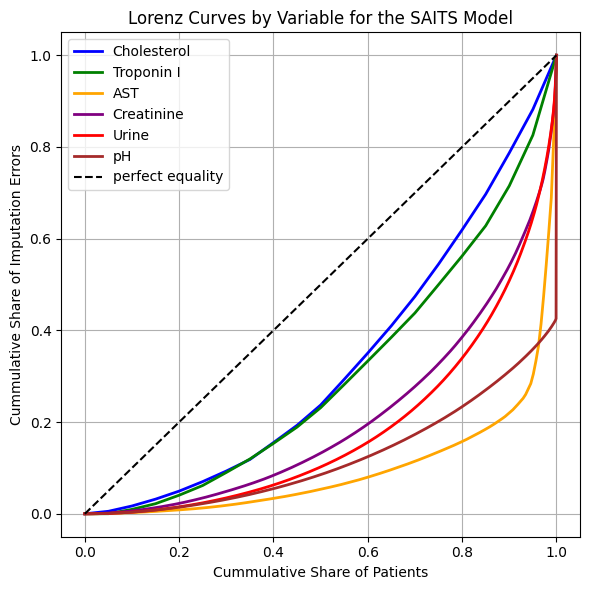

In [68]:
lorenz_curve_5(saits_ae_sum[6], saits_ae_sum[31], saits_ae_sum[2], saits_ae_sum[7], saits_ae_sum[33], saits_ae_sum[36], "Lorenz Curves by Variable for the SAITS Model")

## BRITS

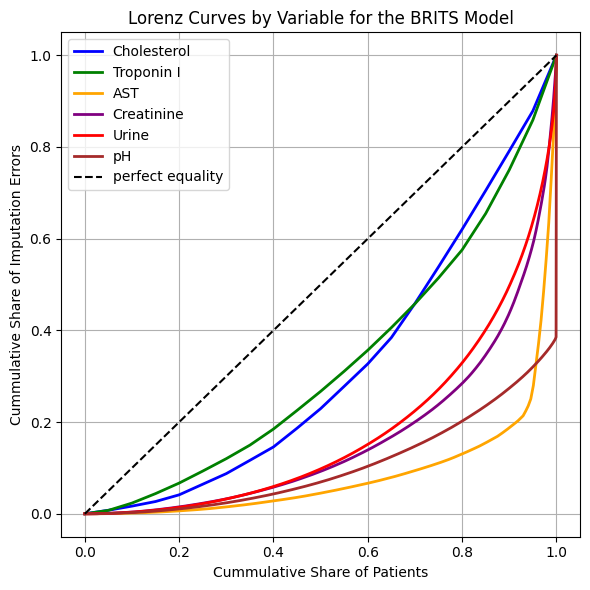

In [84]:
lorenz_curve_5(brits_ae_sum[6], brits_ae_sum[31], brits_ae_sum[2], brits_ae_sum[7], brits_ae_sum[33], brits_ae_sum[36], "Lorenz Curves by Variable for the BRITS Model")

## USGAN

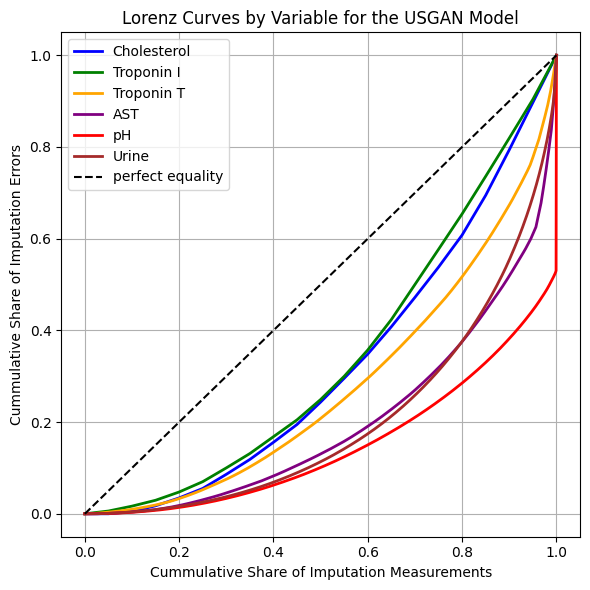

In [49]:
lorenz_curve_5(usgan_ae_mask[6], usgan_ae_mask[31], usgan_ae_mask[32], usgan_ae_mask[2], usgan_ae_mask[36], usgan_ae_mask[33], "Lorenz Curves by Variable for the USGAN Model")

## GPVAE

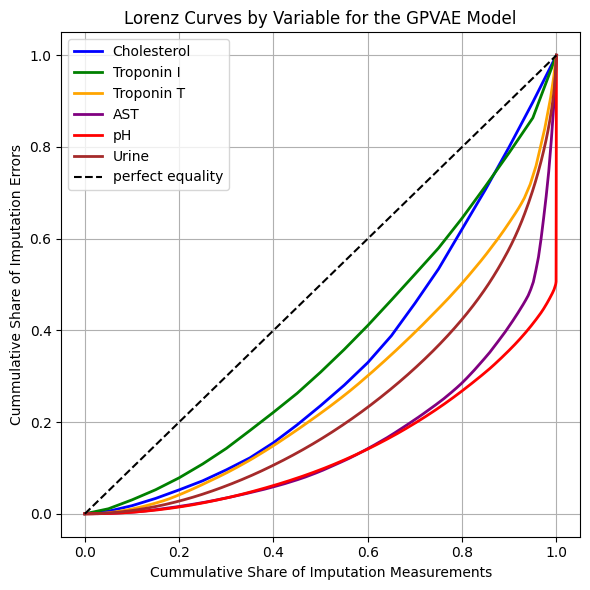

In [50]:
lorenz_curve_5(gpvae_ae_mask[6], gpvae_ae_mask[31], gpvae_ae_mask[32], gpvae_ae_mask[2], gpvae_ae_mask[36], gpvae_ae_mask[33], "Lorenz Curves by Variable for the GPVAE Model")

## MRNN

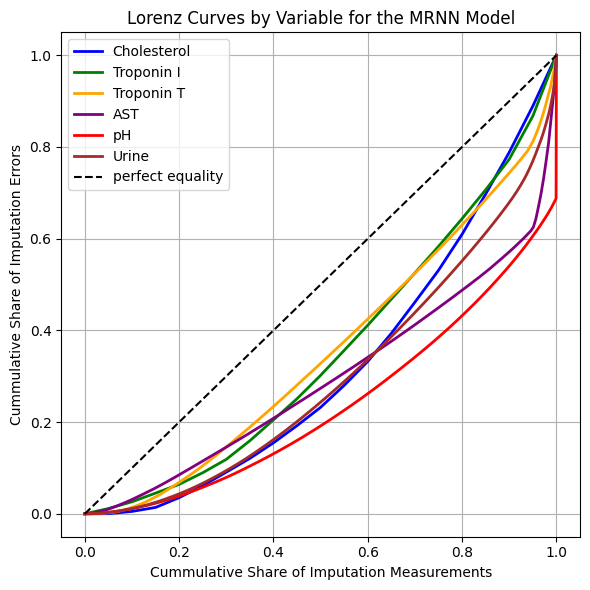

In [51]:
lorenz_curve_5(mrnn_ae_mask[6], mrnn_ae_mask[31], mrnn_ae_mask[32], mrnn_ae_mask[2], mrnn_ae_mask[36], mrnn_ae_mask[33], "Lorenz Curves by Variable for the MRNN Model")

## Scatter Plot Gini vs MAE

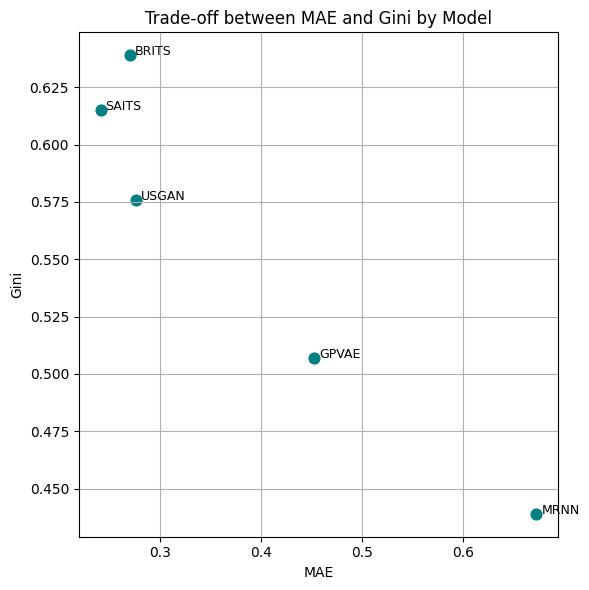

In [ ]:
model_names = ['SAITS', 'BRITS', 'USGAN', 'GPVAE', 'MRNN']
mae = [0.241, 0.270, 0.276, 0.452, 0.672] 
gini = [0.615, 0.639, 0.576, 0.507, 0.439]  

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(mae, gini, color='teal', s=60)

for i, name in enumerate(model_names):
    plt.text(mae[i] + 0.005, gini[i], name, fontsize=9)

plt.xlabel("MAE")
plt.ylabel("Gini")
plt.title("Trade-off between MAE and Gini by Model")
plt.grid(True)
plt.tight_layout()
plt.savefig("trade_off_between_mae_and_gini.pdf", format='pdf', bbox_inches='tight')
plt.show()


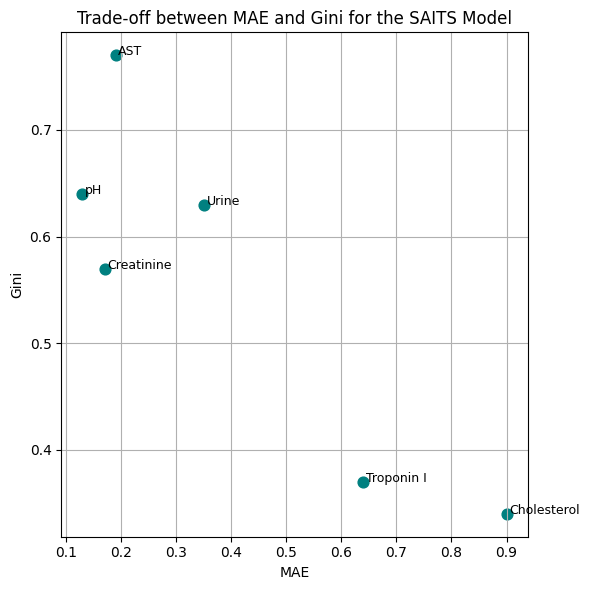

In [62]:
variables_names = ['Cholesterol', 'Troponin I', 'AST', 'Creatinine', 'Urine', 'pH']
mae = [0.90, 0.64, 0.19, 0.17, 0.35, 0.13] 
gini = [0.34, 0.37, 0.77, 0.57, 0.63, 0.64]  

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(mae, gini, color='teal', s=60)

for i, name in enumerate(variables_names):
    plt.text(mae[i] + 0.005, gini[i], name, fontsize=9)

plt.xlabel("MAE")
plt.ylabel("Gini")
plt.title("Trade-off between MAE and Gini for the SAITS Model")
plt.grid(True)
plt.tight_layout()
plt.savefig("trade_off_between_mae_and_gini_SAITS.pdf", format='pdf', bbox_inches='tight')
plt.show()


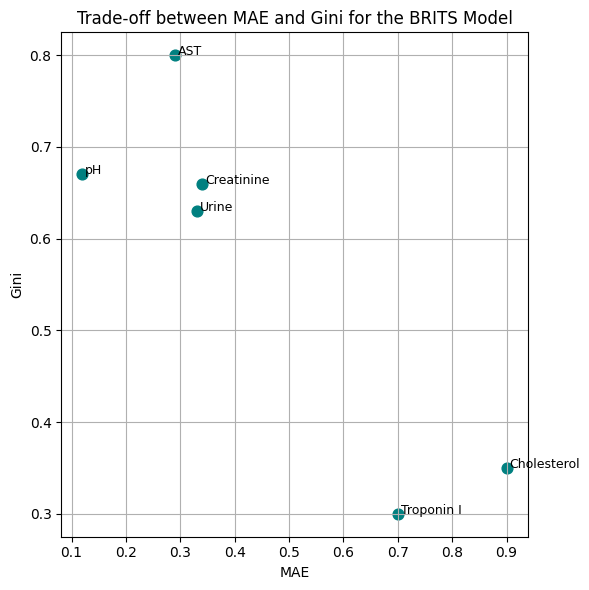

In [63]:
variables_names = ['Cholesterol', 'Troponin I', 'AST', 'Creatinine', 'Urine', 'pH']
mae = [0.90, 0.70, 0.29, 0.34, 0.33, 0.12] 
gini = [0.35, 0.30, 0.80, 0.66, 0.63, 0.67]  

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(mae, gini, color='teal', s=60)

for i, name in enumerate(variables_names):
    plt.text(mae[i] + 0.005, gini[i], name, fontsize=9)

plt.xlabel("MAE")
plt.ylabel("Gini")
plt.title("Trade-off between MAE and Gini for the BRITS Model")
plt.grid(True)
plt.tight_layout()
plt.savefig("trade_off_between_mae_and_gini_BRITS.pdf", format='pdf', bbox_inches='tight')
plt.show()


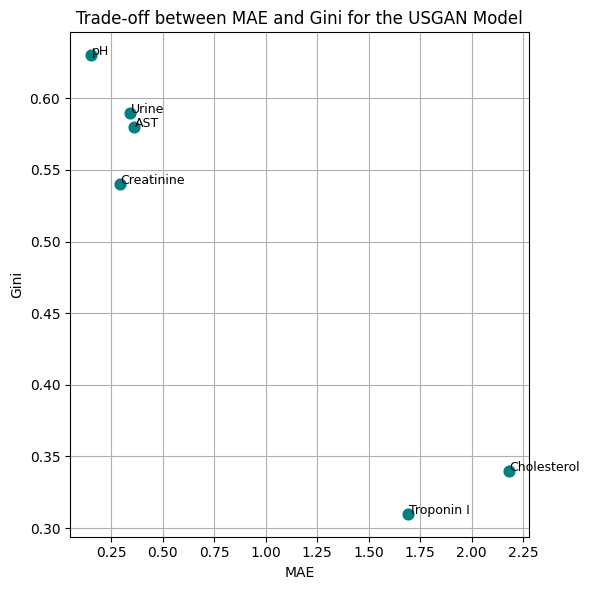

In [64]:
variables_names = ['Cholesterol', 'Troponin I', 'AST', 'Creatinine', 'Urine', 'pH']
mae = [2.18, 1.69, 0.36, 0.29, 0.34, 0.15] 
gini = [0.34, 0.31, 0.58, 0.54, 0.59, 0.63]  

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(mae, gini, color='teal', s=60)

for i, name in enumerate(variables_names):
    plt.text(mae[i] + 0.005, gini[i], name, fontsize=9)

plt.xlabel("MAE")
plt.ylabel("Gini")
plt.title("Trade-off between MAE and Gini for the USGAN Model")
plt.grid(True)
plt.tight_layout()
plt.savefig("trade_off_between_mae_and_gini_USGAN.pdf", format='pdf', bbox_inches='tight')
plt.show()


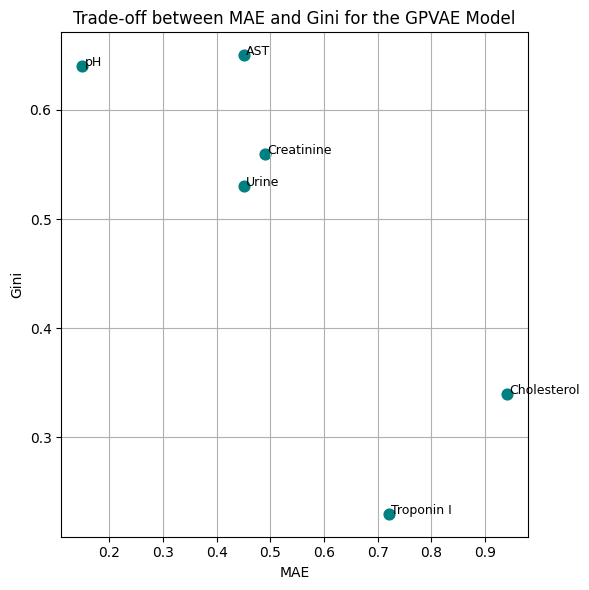

In [65]:
variables_names = ['Cholesterol', 'Troponin I', 'AST', 'Creatinine', 'Urine', 'pH']
mae = [0.94, 0.72, 0.45, 0.49, 0.45, 0.15] 
gini = [0.34, 0.23, 0.65, 0.56, 0.53, 0.64]  

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(mae, gini, color='teal', s=60)

for i, name in enumerate(variables_names):
    plt.text(mae[i] + 0.005, gini[i], name, fontsize=9)

plt.xlabel("MAE")
plt.ylabel("Gini")
plt.title("Trade-off between MAE and Gini for the GPVAE Model")
plt.grid(True)
plt.tight_layout()
plt.savefig("trade_off_between_mae_and_gini_GPVAE.pdf", format='pdf', bbox_inches='tight')
plt.show()


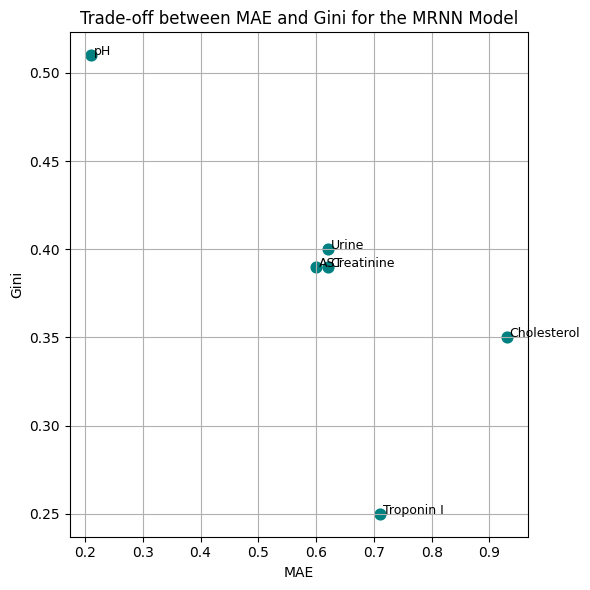

In [66]:
variables_names = ['Cholesterol', 'Troponin I', 'AST', 'Creatinine', 'Urine', 'pH']
mae = [0.93, 0.71, 0.60, 0.62, 0.62, 0.21] 
gini = [0.35, 0.25, 0.39, 0.39, 0.40, 0.51]  

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(mae, gini, color='teal', s=60)

for i, name in enumerate(variables_names):
    plt.text(mae[i] + 0.005, gini[i], name, fontsize=9)

plt.xlabel("MAE")
plt.ylabel("Gini")
plt.title("Trade-off between MAE and Gini for the MRNN Model")
plt.grid(True)
plt.tight_layout()
plt.savefig("trade_off_between_mae_and_gini_MRNN.pdf", format='pdf', bbox_inches='tight')
plt.show()


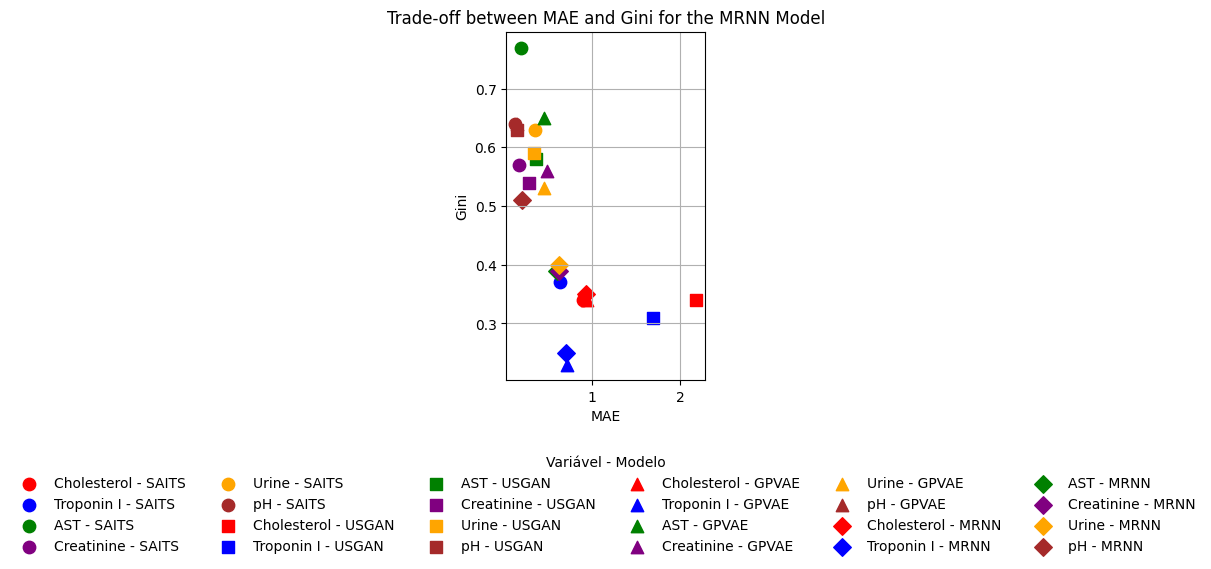

In [66]:
import matplotlib.pyplot as plt

variables_names = ['Cholesterol', 'Troponin I', 'AST', 'Creatinine', 'Urine', 'pH']
models = ['SAITS', 'USGAN', 'GPVAE', 'MRNN']

mae_saits = [0.90, 0.64, 0.19, 0.17, 0.35, 0.13] 
gini_saits = [0.34, 0.37, 0.77, 0.57, 0.63, 0.64]  

mae_usgan = [2.18, 1.69, 0.36, 0.29, 0.34, 0.15] 
gini_usgan = [0.34, 0.31, 0.58, 0.54, 0.59, 0.63]

mae_gpvae = [0.94, 0.72, 0.45, 0.49, 0.45, 0.15] 
gini_gpvae = [0.34, 0.23, 0.65, 0.56, 0.53, 0.64] 

mae_mrnn = [0.93, 0.71, 0.60, 0.62, 0.62, 0.21] 
gini_mrnn = [0.35, 0.25, 0.39, 0.39, 0.40, 0.51]  

x_data = [mae_saits, mae_usgan, mae_gpvae, mae_mrnn]
y_data = [gini_saits, gini_usgan, gini_gpvae , gini_mrnn]

# Lista de cores e marcadores
color_map = {
    'Cholesterol': 'red', 'Troponin I': 'blue', 'AST': 'green',
    'Creatinine': 'purple', 'Urine': 'orange', 'pH': 'brown'
}

marker_map = {
    'SAITS': 'o', 'USGAN': 's', 'GPVAE': '^', 'MRNN': 'D'
}


plt.figure(figsize=(8, 6))
legend_handles = []
# Plotando os pontos
for model_idx, model in enumerate(models):
    x_vals = x_data[model_idx]
    y_vals = y_data[model_idx]
    marker = marker_map[model]

    for i, var in enumerate(variables_names):
        x = x_vals[i]
        y = y_vals[i]
        color = color_map[var]
        label = f"{var} - {model}"

        point = plt.scatter(x, y, color=color, marker=marker, s=80, label=label)
        legend_handles.append(point)


plt.xlabel("MAE")
plt.ylabel("Gini")
plt.title("Trade-off between MAE and Gini for the MRNN Model")
plt.grid(True)

plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=6,
    title="Variável - Modelo",
    frameon=False
)

plt.tight_layout()
plt.savefig("t.pdf", format='pdf', bbox_inches='tight')
plt.show()


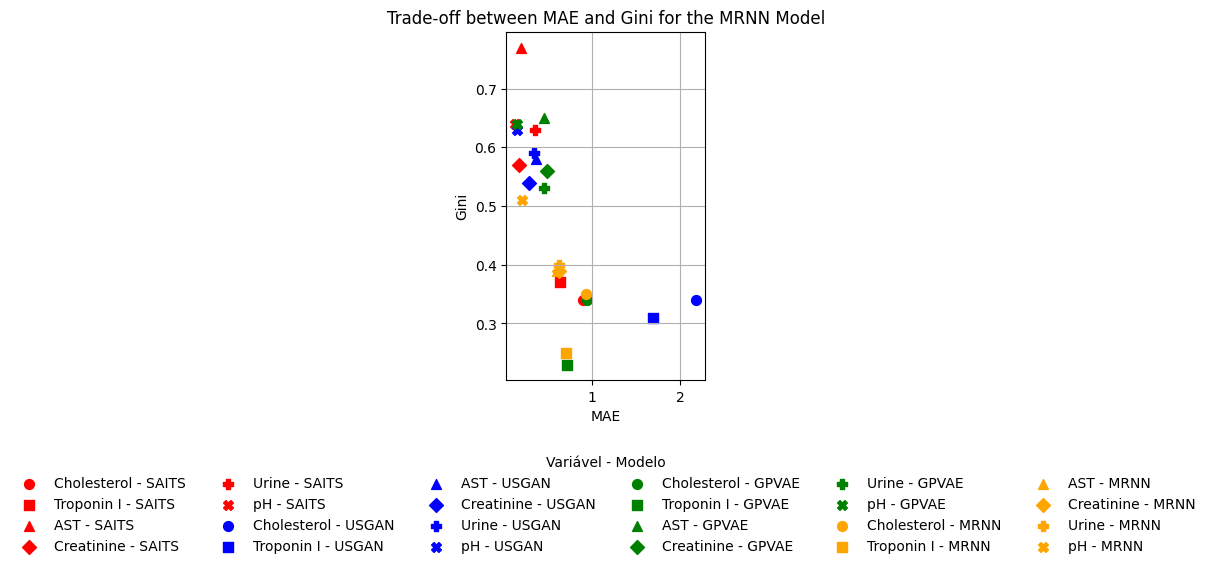

In [71]:
import matplotlib.pyplot as plt

variables_names = ['Cholesterol', 'Troponin I', 'AST', 'Creatinine', 'Urine', 'pH']
models = ['SAITS', 'USGAN', 'GPVAE', 'MRNN']

mae_saits = [0.90, 0.64, 0.19, 0.17, 0.35, 0.13] 
gini_saits = [0.34, 0.37, 0.77, 0.57, 0.63, 0.64]  

mae_usgan = [2.18, 1.69, 0.36, 0.29, 0.34, 0.15] 
gini_usgan = [0.34, 0.31, 0.58, 0.54, 0.59, 0.63]

mae_gpvae = [0.94, 0.72, 0.45, 0.49, 0.45, 0.15] 
gini_gpvae = [0.34, 0.23, 0.65, 0.56, 0.53, 0.64] 

mae_mrnn = [0.93, 0.71, 0.60, 0.62, 0.62, 0.21] 
gini_mrnn = [0.35, 0.25, 0.39, 0.39, 0.40, 0.51]  

x_data = [mae_saits, mae_usgan, mae_gpvae, mae_mrnn]
y_data = [gini_saits, gini_usgan, gini_gpvae , gini_mrnn]

# Lista de cores e marcadores
color_map = {
    'SAITS': 'red', 'USGAN': 'blue', 'GPVAE': 'green',
    'MRNN': 'orange'
}

marker_map = {
    'Cholesterol': 'o', 'Troponin I': 's', 'AST': '^', 'Creatinine': 'D', 'Urine': 'P', 'pH': 'X'
}


plt.figure(figsize=(8, 6))
legend_handles = []
# Plotando os pontos
for model_idx, model in enumerate(models):
    x_vals = x_data[model_idx]
    y_vals = y_data[model_idx]
    color = color_map[model]

    for i, var in enumerate(variables_names):
        x = x_vals[i]
        y = y_vals[i]
        marker = marker_map[var]
        label = f"{var} - {model}"

        point = plt.scatter(x, y, color=color, marker=marker, s=50, label=label)
        legend_handles.append(point)


plt.xlabel("MAE")
plt.ylabel("Gini")
plt.title("Trade-off between MAE and Gini for the MRNN Model")
plt.grid(True)

plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=6,
    title="Variável - Modelo",
    frameon=False
)

plt.tight_layout()
plt.savefig("t.pdf", format='pdf', bbox_inches='tight')
plt.show()


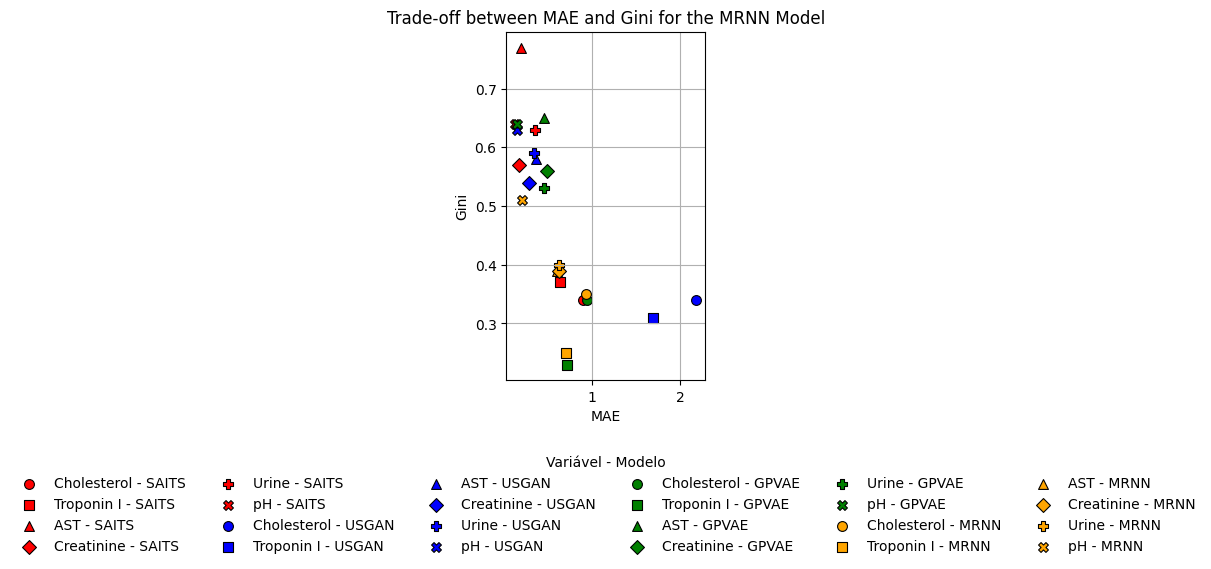

In [75]:
import matplotlib.pyplot as plt

variables_names = ['Cholesterol', 'Troponin I', 'AST', 'Creatinine', 'Urine', 'pH']
models = ['SAITS', 'USGAN', 'GPVAE', 'MRNN']

mae_saits = [0.90, 0.64, 0.19, 0.17, 0.35, 0.13] 
gini_saits = [0.34, 0.37, 0.77, 0.57, 0.63, 0.64]  

mae_usgan = [2.18, 1.69, 0.36, 0.29, 0.34, 0.15] 
gini_usgan = [0.34, 0.31, 0.58, 0.54, 0.59, 0.63]

mae_gpvae = [0.94, 0.72, 0.45, 0.49, 0.45, 0.15] 
gini_gpvae = [0.34, 0.23, 0.65, 0.56, 0.53, 0.64] 

mae_mrnn = [0.93, 0.71, 0.60, 0.62, 0.62, 0.21] 
gini_mrnn = [0.35, 0.25, 0.39, 0.39, 0.40, 0.51]  

x_data = [mae_saits, mae_usgan, mae_gpvae, mae_mrnn]
y_data = [gini_saits, gini_usgan, gini_gpvae , gini_mrnn]

# Lista de cores e marcadores
color_map = {
    'SAITS': 'red', 'USGAN': 'blue', 'GPVAE': 'green',
    'MRNN': 'orange'
}

marker_map = {
    'Cholesterol': 'o', 'Troponin I': 's', 'AST': '^', 'Creatinine': 'D', 'Urine': 'P', 'pH': 'X'
}


plt.figure(figsize=(8, 6))
legend_handles = []
# Plotando os pontos
for model_idx, model in enumerate(models):
    x_vals = x_data[model_idx]
    y_vals = y_data[model_idx]
    color = color_map[model]

    for i, var in enumerate(variables_names):
        x = x_vals[i]
        y = y_vals[i]
        marker = marker_map[var]
        label = f"{var} - {model}"

        point = plt.scatter(x, y, color=color, marker=marker, s=50,  # tamanho menor
            edgecolors='black',  # borda preta
            linewidths=0.8,
            label=label)
        legend_handles.append(point)


plt.xlabel("MAE")
plt.ylabel("Gini")
plt.title("Trade-off between MAE and Gini for the MRNN Model")
plt.grid(True)

plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=6,
    title="Variável - Modelo",
    frameon=False
)

plt.tight_layout()
plt.savefig("t.pdf", format='pdf', bbox_inches='tight')
plt.show()
